In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:theory_measurementError)=
# Example: Measuring Air Quality

Across the US, [sensors to measure air pollution are widely used](https://web-strategist.com/blog/2020/09/20/how-the-crowd-provides-air-quality-data/) by individuals, community groups, and state and local air monitoring agencies. For example, on two days in September 2020, approximately 600,000 Californians and 500,000 Oregonians viewed PurpleAir’s map as fire spread through their states and evacuations were planned. ([PurpleAir](https://www2.purpleair.com) creates air quality maps from crowdsourced data that streams in from its sensors.) 

The sensors measure the amount of particulate matter in the air that has a diameter smaller than 2.5 micrometers (the unit of measurement is micrograms per cubic meter: μg/m<sup>3</sup>). The measurements recorded are the average concentrations over two minutes. While the level of particulate matter changes over the course of a day as, for example, people commute to and from work, there are certain times of the day, like at midnight, when we expect the two minute averages to change little in a half hour. If we examine the measurements taken during these times of the day, we can get a sense of the combined variability in the instrument recordings and the mixing of particles in the air. 

Anyone can access sensor measurements from PurpleAir's site. The site provides a download tool, and data are available for any sensor that appears on PurpleAir's map. We downloaded data from one sensor over a 24-hour period and selected three half-hour time intervals spread  throughout the day where the readings were roughly constant over the 30-minute period. This gave us three sets of 15 two-minute averages, for a total of 45 measurements:

In [2]:
pm = pd.read_csv('data/pm30.csv')
pm

,aq2.5,time,hour,meds,diff30
0,6.14,2022-04-01 00:01:10 UTC,0,5.38,0.59
1,5.00,2022-04-01 00:03:10 UTC,0,5.38,-0.55
2,5.29,2022-04-01 00:05:10 UTC,0,5.38,-0.26
...,...,...,...,...,...
42,7.55,2022-04-01 19:27:20 UTC,19,8.55,-1.29
43,9.47,2022-04-01 19:29:20 UTC,19,8.55,0.63
44,8.55,2022-04-01 19:31:20 UTC,19,8.55,-0.29


Line plots can give us a sense of variation in the measurements. In one 30-minute period, we expect the measurements to be roughly the same, with the exception of minor variations from the particles moving in the air and the measurement error of the instrument:

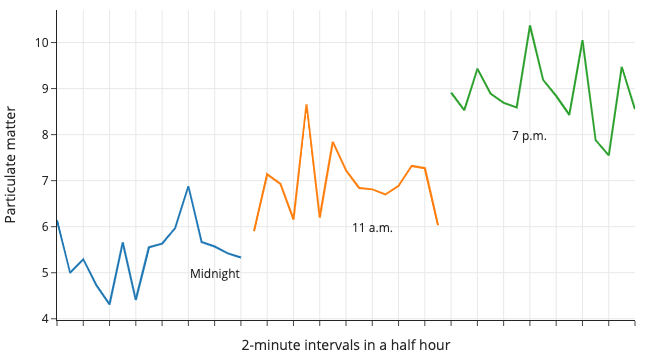

In [3]:
fig = px.line(pm, x="time", y="aq2.5", color="hour",
             labels={
        "time": "2-minute intervals in a half hour",
        "aq2.5": "Particulate matter",
    }
      )

fig.add_annotation(x=12, y=5, text="Midnight", showarrow=False)
fig.add_annotation(x=24, y=6, text="11 a.m.", showarrow=False)
fig.add_annotation(x=36, y=8, text="7 p.m.", showarrow=False)

fig.update_xaxes(showticklabels=False)
fig.update_layout(width=500, height=250, showlegend=False)

fig.show()

The plot shows us how the air quality worsens throughout the day, but in each of these half-hour intervals, the air quality is roughly constant at 5.4, 6.6, and 8.6 μg/m<sup>3</sup> at midnight, 11 a.m., and 7 p.m., respectively.  We can think of the data scope as follows: at this particular location in a specific half-hour time interval, there is an average particle concentration in the air surrounding the sensor. This concentration is our target, and our instrument, the sensor, takes many measurements that form a sample from the access frame. (See {numref}`Chapter %s <ch:data_scope>` for the dart board analogy of this process.) If the instrument is working properly, the measurements are centered on the target: the 30-minute average.  

To get a better sense of the variation in a half-hour interval, we can examine the differences of the measurements from the median for the corresponding half hour. The distribution of these "errors" is as follows:

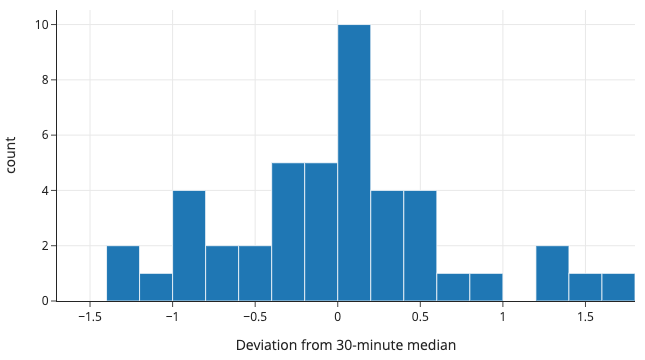

In [4]:
fig = px.histogram(pm, x='diff30', nbins=20,
                   labels={'diff30':'Deviation from 30-minute median'})

fig.update_xaxes(range=[-1.7, 1.8])
fig.update_layout(width=350, height=250)                     

The histogram shows us that the typical fluctuations in measurements are often less than 0.5 μg/m<sup>3</sup> and rarely greater than 1 μg/m<sup>3</sup>. With instruments, we often consider their _relative standard error_, which is the standard deviation as a percentage of the mean. The standard deviation of these 45 deviations is:

In [135]:
np.std(pm['diff30'])

0.6870817156282193

Given that the hourly measurements range from 5 to 9 μg/m<sup>3</sup>, the relative error is 8% to 12%, which is reasonably accurate.

We can use the urn model to simulate the variability in this measurement process. We place in the urn the deviations of the measurements from their 30-minute medians for all 45 readings, and we simulate a 30-minute air quality sequence of measurements by drawing 15 times *with replacement* from the urn and adding the deviations drawn to a hypothetical 30-minute average: 

In [4]:
urn = pm["diff30"]

In [5]:
np.random.seed(221212)
sample_err = np.random.choice(urn, size=15, replace=True)
aq_imitate = 11 + sample_err

We can add a line plot for this artificial set of measurements to our earlier line plots, and compare it to the three real ones:

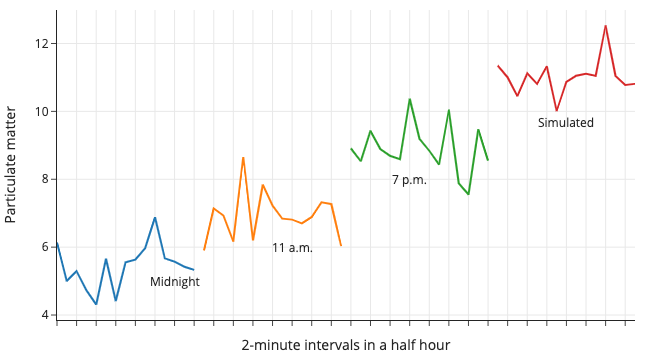

In [6]:
times = np.arange(1, 16)

fig = px.line(
    pm,
    x="time",
    y="aq2.5",
    color="hour",
    labels={
        "time": "2-minute intervals in a half hour",
        "aq2.5": "Particulate matter",
    },
)

fig.add_trace(go.Scatter(x=times, y=aq_imitate, mode="lines"))

fig.add_annotation(x=12, y=5, text="Midnight", showarrow=False)
fig.add_annotation(x=24, y=6, text="11 a.m.", showarrow=False)
fig.add_annotation(x=36, y=8, text="7 p.m.", showarrow=False)
fig.add_annotation(x=52, y=9.7, text="Simulated", showarrow=False)
fig.update_xaxes(showticklabels=False)
fig.update_layout(width=500, height=250, showlegend=False)

fig.show()

The shape of the line plot from the simulated data is similar to the others, which indicates that our model for the measurement process is reasonable.  Unfortunately, what we don't know is whether the measurements are close to the true air quality. To detect bias in the instrument, we need to make comparisons against a more accurate instrument or take measurements in a protected environment where the air has a known quantity of particulate matter. In fact, [researchers](https://thebolditalic.com/understanding-purpleair-vs-airnow-gov-measurements-of-wood-smoke-pollution-562923a55226) have found that low humidity can distort the readings so that they are too high. In {numref}`Chapter %s <ch:pa>`, we carry out a more comprehensive analysis of the PurpleAir sensor data and calibrate the instruments to improve their accuracy.